In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("Yes folder exists:", Path("yes").exists())
print("No folder exists:", Path("no").exists())


NameError: name 'Path' is not defined

Using device: cpu
Model has: 23505858 parameters


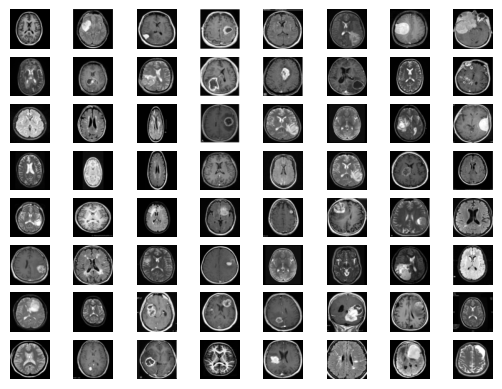

In [ ]:
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from pathlib import Path
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
from PIL import Image

torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(in_features=2048, out_features=2, bias=True)
model.to(device)

number_of_parameters = sum(x.numel() for x in model.parameters())
print(f"Model has: {number_of_parameters} parameters")

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-4, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=100)

class BrainDataset(Dataset):
    def __init__(self):
        self.no_images = list(Path("/content/drive/MyDrive/datasets/brain_tumor_dataset/no").glob("*"))
        self.yes_images = list(Path("/content/drive/MyDrive/datasets/brain_tumor_dataset/yes").glob("*"))
        self.transform = v2.Compose([
            v2.Resize((64, 64)),
            v2.Grayscale(num_output_channels=1),
            v2.ToTensor(),
            v2.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.no_images) + len(self.yes_images)

    def __getitem__(self, idx):
        if idx < len(self.no_images):
            image_path = self.no_images[idx]
            label = 0
        else:
            image_path = self.yes_images[idx - len(self.no_images)]
            label = 1

        image = Image.open(image_path).convert("L")
        tensor = self.transform(image)

        return tensor, label

dataset = BrainDataset()
test_perc = 0.3
test_len = int(len(dataset) * test_perc)
train_len = len(dataset) - test_len
train_data, test_data = random_split(dataset, [train_len, test_len])

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=2)

fig, axes = plt.subplots(8, 8)
axes = axes.flatten()

batch, labels = next(iter(train_dataloader))

for i in range(64):
    image = batch[i].numpy()[0]
    axes[i].imshow(image, cmap="gray")
    axes[i].axis("off")
plt.show()

@torch.no_grad()
def get_accuracy(y_true, y_pred):
    correct = (y_true == y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc


In [ ]:

train_loss_list = []
val_loss_list = []
accuracy_list = []
num_epochs = 45

for epoch in range(num_epochs):
    train_loss = 0

    model.train()
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    scheduler.step()

    model.eval()
    val_loss, accuracy = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            val_loss += criterion(output, labels).item()

            predictions = output.argmax(1)
            accuracy += get_accuracy(labels, predictions)

    train_loss /= len(train_dataloader)
    val_loss /= len(test_dataloader)
    accuracy /= len(test_dataloader)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    accuracy_list.append(accuracy)

    print(f"Epoch: {epoch}. Train loss: {train_loss}. Validation loss: {val_loss}. Accuracy: {accuracy}")


Epoch: 0. Train loss: 0.6700620253880819. Validation loss: 0.5932100713253021. Accuracy: 64.63068181818181
Epoch: 1. Train loss: 0.468764732281367. Validation loss: 1.6952556371688843. Accuracy: 33.80681818181819
Epoch: 2. Train loss: 0.2826887269814809. Validation loss: 6.677785396575928. Accuracy: 30.184659090909093
Epoch: 3. Train loss: 0.14404736955960593. Validation loss: 2.389690637588501. Accuracy: 43.96306818181819
Epoch: 4. Train loss: 0.06929428627093633. Validation loss: 1.770678699016571. Accuracy: 58.38068181818181
Epoch: 5. Train loss: 0.07243479043245316. Validation loss: 1.4859338402748108. Accuracy: 61.647727272727266
Epoch: 6. Train loss: 0.027364994399249554. Validation loss: 1.1934854388237. Accuracy: 78.4090909090909
Epoch: 7. Train loss: 0.020809803778926533. Validation loss: 0.9574925899505615. Accuracy: 77.6278409090909
Epoch: 8. Train loss: 0.010274494610105952. Validation loss: 0.8199150562286377. Accuracy: 86.07954545454545
Epoch: 9. Train loss: 0.08259665717

In [ ]:
@torch.no_grad()

def get_accuracy(y_true, y_pred):

    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred))

    return acc



def get_recall(input, target, num_classes):

  metric = MulticlassRecall(average='micro', num_classes=num_classes)

  metric.update(input, target)

  return metric.compute()



def get_precision(input, target, num_classes):

  metric = MulticlassPrecision(average='micro', num_classes=num_classes)

  metric.update(input, target)

  return metric.compute()



def get_precision_and_recall_pytorch(input, target, num_classes):

  return get_precision(input, target, num_classes), get_recall(input, target, num_classes)



@torch.no_grad()

def get_precision_and_recall(input, target, num_classes):

  recall=torch.zeros(num_classes, device=device)

  precision=torch.zeros(num_classes, device=device)



  false_negatives=torch.zeros(num_classes, device=device)

  false_positives=torch.zeros(num_classes, device=device)

  true_positives=torch.zeros(num_classes, device=device)



  confusion_matrix=multiclass_confusion_matrix(input, target, num_classes)



  for i in range(num_classes):

    for j in range(num_classes):

      if i==j:

        true_positives[i]=confusion_matrix[i][i]

      else:

        false_negatives[i]+=confusion_matrix[i][j]

        false_positives[j]+=confusion_matrix[i][j]

  precision_counter, recall_counter = 0, 0
  for i in range(num_classes):

    if true_positives[i]+false_negatives[i]!=0:
        precision[i]=(true_positives[i]/(true_positives[i]+false_negatives[i]))
        precision_counter += 1

    if true_positives[i]+false_positives[i]!=0:
        recall[i]=(true_positives[i]/(true_positives[i]+false_positives[i]))
        recall_counter += 1

  precision = precision.sum() / precision_counter
  recall = recall.sum() / recall_counter

  return precision, recall
